# 0x0E.Time Series Forecasting - Forecast Bitcoin




import of library

In [118]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import regularizers


## preprocessing the data 

In [119]:
# Extract dataframe from csv and visualize it
coinbase_df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip')
print(coinbase_df.shape)
coinbase_df.describe()


(2099760, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.099760e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06
mean,1.483899e+09,3.246403e+03,3.247829e+03,3.244856e+03,3.246403e+03,7.849139e+00,3.600157e+04,3.246341e+03
std,3.638214e+07,3.799154e+03,3.801394e+03,3.796761e+03,3.799150e+03,1.873222e+01,1.401879e+05,3.799078e+03
min,1.417412e+09,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08,2.641700e-06,6.000000e-02
25%,1.452410e+09,4.195800e+02,4.196400e+02,4.195000e+02,4.195700e+02,9.024000e-01,6.440031e+02,4.195645e+02
50%,1.483906e+09,1.014580e+03,1.014890e+03,1.014150e+03,1.014530e+03,2.692900e+00,3.695642e+03,1.014512e+03
75%,1.515402e+09,6.322630e+03,6.324010e+03,6.321090e+03,6.322670e+03,7.600965e+00,1.972392e+04,6.322550e+03
max,1.546899e+09,1.989199e+04,1.989199e+04,1.989198e+04,1.989199e+04,1.563267e+03,1.997076e+07,1.989199e+04


In [120]:
# Dealing with missing values 
print(coinbase_df.isna().sum())
df = coinbase_df.dropna()
print('-----------------------------')
df.isna().sum()

Timestamp                 0
Open                 109069
High                 109069
Low                  109069
Close                109069
Volume_(BTC)         109069
Volume_(Currency)    109069
Weighted_Price       109069
dtype: int64
-----------------------------


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [121]:
# Encode the date
df['date'] = [datetime.datetime.utcfromtimestamp(x) for x in df['Timestamp']]
date_time = pd.to_datetime(df.pop('Timestamp'), unit='s')
date = date_time.map(datetime.datetime.timestamp)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,300.0,300.0,300.0,300.0,0.010000,3.00000,300.0,2014-12-01 05:33:00
7,300.0,300.0,300.0,300.0,0.010000,3.00000,300.0,2014-12-01 05:40:00
51,370.0,370.0,370.0,370.0,0.010000,3.70000,370.0,2014-12-01 06:24:00
77,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0,2014-12-01 06:50:00
1436,377.0,377.0,377.0,377.0,0.010000,3.77000,377.0,2014-12-02 05:29:00


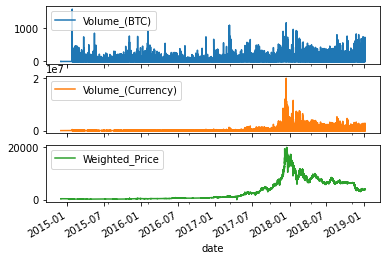

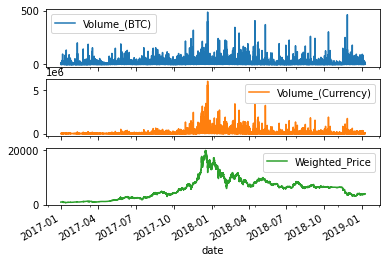

In [122]:
plot_cols = ['Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']
plot_features = df[plot_cols]
plot_features.index = df['date']
_ = plot_features.plot(subplots=True)
df = df[df['date'] >= '2017']
df = df[0::60]
df['date']
plot_cols = ['Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']
plot_features = df[plot_cols]
plot_features.index = df['date']
_ = plot_features.plot(subplots=True)

In [123]:
# Split the data
#(80%, 15%, 5%) split for the training, validation, and test sets.
n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.95)]
test_df = df[int(n*0.95):]

num_features = df.shape[1]
print(num_features)
# Min-Max normalization 
train_df = (train_df-train_df.min())/(train_df.max()-train_df.min())
val_df = (val_df-val_df.min())/(val_df.max()-val_df.min())
test_df = (test_df-test_df.min())/(test_df.max()-test_df.min())
train_df


8


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
1038593,0.0114778,0.0114732,0.0114773,0.0114763,0.0043703,0.000340916,0.0114774,0.000000
1038662,0.0113973,0.011401,0.0113978,0.0114052,0.00305906,0.000238281,0.011403,0.000081
1038738,0.0113476,0.0113691,0.0113476,0.0113733,0.0024231,0.000188576,0.0113577,0.000170
1038800,0.0112147,0.0112294,0.0111844,0.0111834,0.0123678,0.00096002,0.0112262,0.000243
1038860,0.0111561,0.0111896,0.0111452,0.0111839,0.00542075,0.00042022,0.0111595,0.000314
...,...,...,...,...,...,...,...,...
1889582,0.28088,0.280877,0.280889,0.280893,0.0064969,0.0031882,0.280879,0.999718
1889642,0.286254,0.286251,0.285785,0.286111,0.0910102,0.0453673,0.285945,0.999789
1889702,0.285941,0.285938,0.285798,0.285797,0.00812399,0.00404891,0.285881,0.999859
1889762,0.286673,0.287031,0.286687,0.287048,0.00904396,0.00452123,0.286879,0.999930


## Data windowing

> 1. Indexes and offsets

> 2. Split

> 3. Create tf.data.Datasets

> 4. Plot



In [124]:
# Ceating the WindowGenerator class
# -----------------------------------------------------------------------------
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [125]:
w1 = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Weighted_Price'])

w1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Weighted_Price']

In [126]:
# Split to window
# -----------------------------------------------------------------------------
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [127]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 25, 8)
Inputs shape: (3, 24, 8)
labels shape: (3, 24, 1)


In [128]:
# Create tf.data.Datasets
# -----------------------------------------------------------------------------

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example



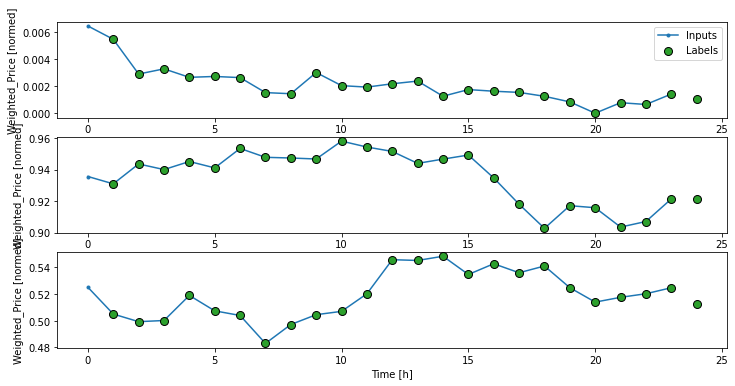

In [129]:
# Plot: simple visualization of the split window
# 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price'
# -----------------------------------------------------------------------------
# w1.example = example_inputs, example_labels
def plot(self, model=None, plot_col='Weighted_Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 6))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#7f0eff', s=64)
    # * train_std + train_mean,
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

WindowGenerator.plot = plot
w1.plot()

## Single step models


> compile and fit model


> Recurrent neural network





In [154]:
# Compile and fit model
# -----------------------------------------------------------------------------
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history



In [155]:
# Recurrent neural network
# -----------------------------------------------------------------------------
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
   # tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, activation='sigmoid', return_sequences=True),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=24)
])
history = compile_and_fit(lstm_model, w1)
IPython.display.clear_output()

In [156]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', lstm_model(w1.example[0]).shape)


Input shape: (32, 24, 8)
Output shape: (32, 24, 24)


82/82 [==============================] - 1s 9ms/step - loss: 9.5510e-04 - mean_absolute_error: 0.0227


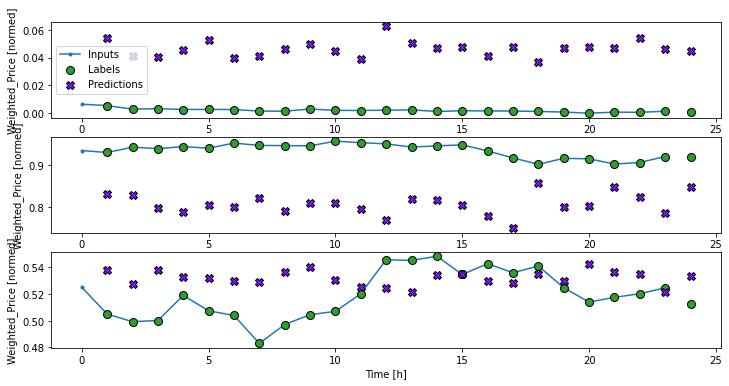

In [157]:
# Plotting the RNN model's predictions 
# -----------------------------------------------------------------------------

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0)

w1.plot(lstm_model)



## Performance

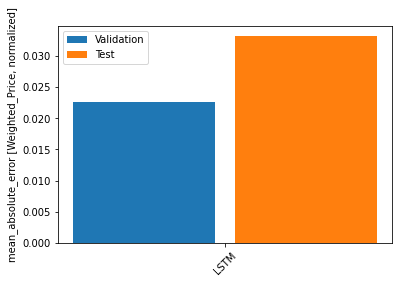

In [158]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Weighted_Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


## Multi-step models


> Single-shot models (RNN)



Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['Weighted_Price']

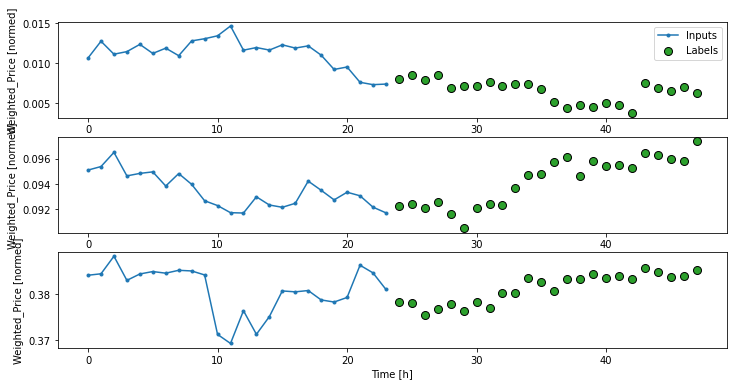

In [140]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=['Weighted_Price'])

multi_window.plot()
multi_window

In [159]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*24,
                          kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None)),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 24])
])

history = compile_and_fit(multi_lstm_model, multi_window)



Epoch 1/30
436/436 [==============================] - 17s 37ms/step - loss: 0.0095 - mean_absolute_error: 0.0505 - val_loss: 0.0043 - val_mean_absolute_error: 0.0557
Epoch 2/30
436/436 [==============================] - 16s 36ms/step - loss: 0.0018 - mean_absolute_error: 0.0266 - val_loss: 0.0022 - val_mean_absolute_error: 0.0383
Epoch 3/30
436/436 [==============================] - 16s 37ms/step - loss: 0.0015 - mean_absolute_error: 0.0246 - val_loss: 0.0017 - val_mean_absolute_error: 0.0308
Epoch 4/30
436/436 [==============================] - 16s 37ms/step - loss: 0.0014 - mean_absolute_error: 0.0244 - val_loss: 0.0021 - val_mean_absolute_error: 0.0379
Epoch 5/30
436/436 [==============================] - 16s 36ms/step - loss: 0.0013 - mean_absolute_error: 0.0232 - val_loss: 0.0015 - val_mean_absolute_error: 0.0268
Epoch 6/30
436/436 [==============================] - 16s 37ms/step - loss: 0.0012 - mean_absolute_error: 0.0232 - val_loss: 0.0017 - val_mean_absolute_error: 0.0270
Epoc

In [160]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_lstm_model(multi_window.example[0]).shape)


Input shape: (32, 24, 8)
Output shape: (32, 24, 24)


81/81 [==============================] - 1s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0395


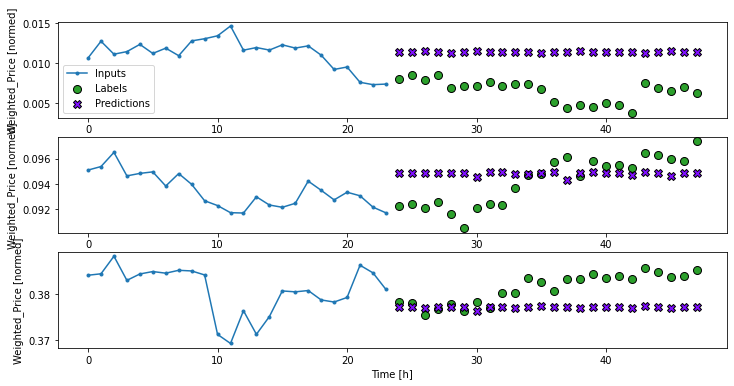

In [161]:
IPython.display.clear_output()
multi_val_performance = {}
multi_performance = {}

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


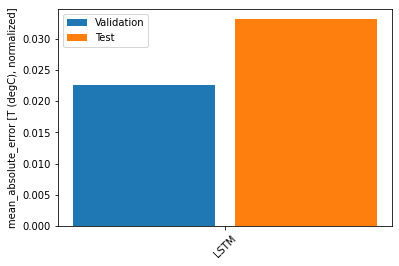

In [162]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()